In [2]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import random
import torch.nn.functional as F
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error


In [3]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [4]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes/outputs
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

In [84]:
def run_classifier_rej(model, exp_heuristic, data_x, data_y, alpha, p, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)


    for epoch in range(1):  # loop over the dataset multiple times
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)
        inputs = inputs.to(torch.float32)

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):

            optimizer.zero_grad()

            # forward + backward + optimize
            rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert k

            selected_expert = exp_heuristic[rand_exp-1]

            h = selected_expert(inputs)
            _, predicted = torch.max(h.data, 1)
            h = (predicted==labels)*1

            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2) # this is loss for classifier and rejector, 2 outputs
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())

    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()   

In [94]:
def classifier_rej(model, exp_heuristic, data_x, data_y, p, k, exp_instances, classifier_index):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)

        h = [(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]
        _, predicted_exp = [torch.max(h.data, 1) for h in h]

        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert for each point
                correct_sys += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp[rand_exp-1] += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp_total[rand_exp-1] += 1
                exp_instances[rand_exp-1].append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
                classifier_index.append(i)
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances, classifier_index

In [7]:
class Linear_net_rej_id(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim, k):
        super(Linear_net_rej_id, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+k) # out: 0,1,2,3
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2,3 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [8]:
def reject_CrossEntropyLoss_id(outputs, h, labels, m, k, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert k cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes, binary here
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs_exp = [torch.zeros(batch_size) for _ in range(k)]

    for i in range(k):
        outputs_exp[i] = -h[i] * torch.log2(outputs[range(batch_size), rc]) - m[:, i] * torch.log2(outputs[range(batch_size), labels])

    outputs = sum(outputs_exp)  # Sum the losses from all experts
    
    return torch.sum(outputs) / batch_size

In [9]:
def run_classifier_rej_id(model, exp_heuristic, data_x, data_y, alpha, beta, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: expert 1 hyperparam alpha for loss L_CE^{\alpha} 
        beta: expert 2 hyperparam alpha for loss L_CE^{\beta} 
        p: probability of randomly selecting expert 1
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.08, betas = (0.75, .1), weight_decay=.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=.3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        inputs = data_x
        inputs= inputs.clone().detach()
        labels = data_y
        labels = labels.clone().detach()

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):
            optimizer.zero_grad()

            predicted = [torch.tensor(expert(inputs)) for expert in exp_heuristic]

            h_list = [(expert_output == labels) * 1 for expert_output in predicted]

            m = torch.zeros(len(inputs), k)

            for j in range(len(inputs)):
                for i in range(k):
                    if h_list[0][j]:
                        m[j][0] = alpha
                    elif h_list[1][j]:
                        m[j][1] = beta
                    else:
                        m[j][i] = 1

            h_list = [h.clone().detach() for h in h_list]
            m = m.clone().detach()

            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss computation
            loss = reject_CrossEntropyLoss_id(outputs, h_list, labels, m, k, 2)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())
    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()  

In [10]:
def classifier_rej_id(model, exp_heuristic, data_x, data_y, k, exp_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_exp = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]

        for i in range(len(inputs)):
            r = predicted[i].item() > 1  # if greater than 1, then defer to experts
            if r:
                expert_id = predicted[i].item() - 2  # expert index starts from 0
                correct_sys += (predicted_exp[expert_id][i] == labels[i]).item()
                exp[expert_id] += (predicted_exp[expert_id][i] == labels[i]).item()
                exp_total[expert_id] += 1
                exp_instances[expert_id].append(i)

            else:
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))
    print()

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances


In [11]:
def reject_CrossEntropyLoss_id(outputs, h, labels, m, k, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert k cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes, binary here
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs_exp = [torch.zeros(batch_size) for _ in range(k)]

    for i in range(k):
        outputs_exp[i] = -h[i] * torch.log2(outputs[range(batch_size), rc]) - m[:, i] * torch.log2(outputs[range(batch_size), labels])

    outputs = sum(outputs_exp)  # Sum the losses from all experts
    
    return torch.sum(outputs) / batch_size

In [12]:
def getSyntheticDataset(m_values, s_values, sizes, flip_prob=0.5):
    X, y, groups = [], [], []
    num_clusters = len(m_values)
    
    # Generate data for each cluster
    for cluster_idx in range(num_clusters):
        m = m_values[cluster_idx]
        s = s_values[cluster_idx]
        total = sizes[cluster_idx]
        
        # Generate data points for the current cluster
        mu = np.array(m)  # Mean vector for the cluster
        sig = np.diag([s for _ in range(len(m))])  # Diagonal covariance matrix
        
        cluster_data = np.random.multivariate_normal(mu, sig, total)
        X.extend(cluster_data)
        
        # Assign labels and groups
        if cluster_idx == 0:
            # Assign label 0 for all data points in the first cluster
            labels = [0] * total
        elif cluster_idx == 1:
            # Assign label 1 for all data points in the second cluster
            labels = [1] * total
        else:
            # Assign labels randomly based on flip_prob for other clusters
            labels = np.random.choice([0, 1], size=total, p=[1 - flip_prob, flip_prob])
        
        y.extend(labels)
        groups.extend([cluster_idx] * total)
    
    return X, y, groups

In [13]:
def visualize_clusters(X, y, groups, sizes):
    import itertools
    colors = ["orange", "orange", "blue", "green", "gray"]
    markers = [".", "+"]

    indices = list(range(np.sum(sizes)))
    random.shuffle(indices)
    # indices = indices[:500]

    for label, group in itertools.product(np.unique(y), np.unique(groups)):
        x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
        x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
        #leg = "Group " + str(group) + ", Label " + str(label)
        plt.scatter(x1, x2, c=colors[group], marker=markers[label], s=100)
    #plt.legend(ncol=2)

# Synthetic Data

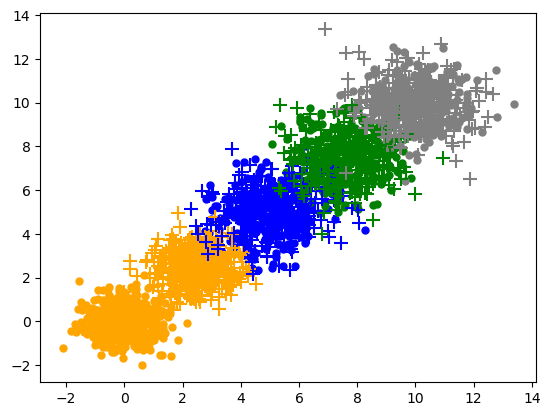

In [14]:
k = 4  # Number of clusters

# Define parameters for each cluster 
m_values = [
    [0, 0],    # Cluster 1
    [2.5, 2.5], # Cluster 2
    [5, 5],    # Cluster 3
    [7.5, 7.5], # Cluster 4
    [10, 10]
]

s_values = [0.5, 0.5, 1.0, 1.0, 1.0]  # Standard deviation for each cluster
sizes = [500, 500, 500, 500, 500]     # Number of data points for each cluster

# Generate synthetic dataset with k clusters
X, y, groups = getSyntheticDataset(m_values, s_values, sizes)

# Visualize clusters
visualize_clusters(X, y, groups, sizes)

In [15]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.3, random_state=42)


# Diverse Experts

In [78]:
class Linear_net(nn.Module):
    '''
    Linear multiclass classifier with unit init
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, out_dim)
        torch.nn.init.ones_(self.fc1.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.softmax(x)
        return x

    def set_slope(self, m):
        with torch.no_grad():
            self.fc1.weight.fill_(m)

In [87]:
k = 2

In [88]:
d = 2
exp_index = [[] for _ in range(k)]
classifier_index = []

In [91]:
exp = [Linear_net(d, 2) for _ in range(k)]
slope = 1
for expert in exp:
    expert.set_slope(slope)
    expert.fc1.bias.data = torch.randn(1)

m = Linear_net_rej(d,2) # 2 inputs
alpha = 0
p = 0.5

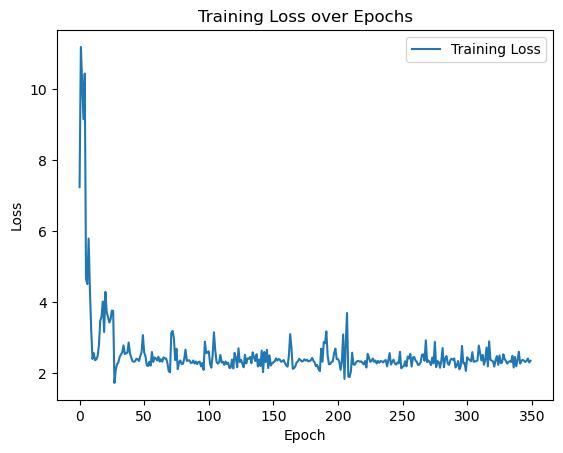

In [92]:
run_classifier_rej(m, exp, X_train, y_train, alpha, p, k)

TODO:
- fix testing code
- expand to k experts
- modify code for id
- apply partial info and expert visibility settings
- add code to train experts separately similar to Mozannar and Sontag

In [95]:
exp_index, classifier_index = classifier_rej(m, exp, X_test, y_test, 1, k, exp_index, classifier_index)

system accuracy 22.266666666666666
total points: 750

Expert 1 defer count: 403
Expert 1 defer percent: 53.733333333333334
Expert 1 correct predictions: 0
Expert 1 accuracy: 0.0

Expert 2 defer count: 0
Expert 2 defer percent: 0
Expert 2 correct predictions: 0
Expert 2 accuracy: 0

Not deferred to any expert count: 347
Not deferred percent: 46.266666666666666
Model correct predictions: 167
Model accuracy: 48.12678728334661

Overall expert count: 403
Overall expert defer percent: 53.733333333333334
Overall expert correct predictions: 0
Overall expert accuracy: 0.0


Slope (weights): [3. 3.]
Intercept (bias): [0.10325074]


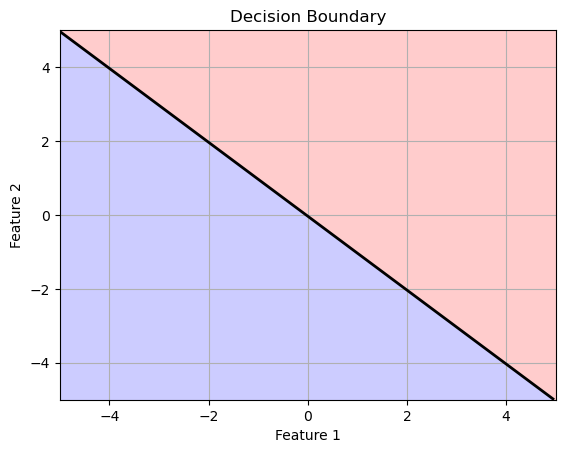

In [77]:
def plot_decision_boundary(model, slope, intercept):
    x_min, x_max = -5, 5  # Define the range for x-axis
    y_min, y_max = -5, 5  # Define the range for y-axis

    # Create a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Calculate the decision boundary
    zz = slope[0] * xx + slope[1] * yy + intercept
    zz = zz.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, zz, levels=[-float('inf'), 0, float('inf')], colors=['blue', 'red'], alpha=0.2)
    plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.grid(True)
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model, slope, intercept)
